Algo : 

......................

Input : phi0, V'(phi0) = 0 (resp eps1 = 1), V(phi0) wanted

......................

1) Tune lambda st V''(phi0) = 0

2) Tune mphi st V'(phi0) = 0 (resp eps1(phi0) = 1)

2) Divide by the same value mphi, A and lambda to get V(phi0) = V(phi0) wanted

......................

Output : mphi, A and lambda

......................

Can do delta params between the two situations V'(phi0) = 0 & eps1 = 1 to deduce the parameter space fraction giving inflation at phi0, V(phi0).

![alt text](Capture.PNG "Fine tuning level")


# Functions

In [5]:
import mpmath as mp
from mpmath import *
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 16, 10

mp.dps = 500
mp.prec = 166

lnMpinGev = mp.mpf('42.334')
Mp = mp.exp(lnMpinGev)

mphi_tree = lambda phi, phigut, mphigut, xi : mphigut
lambda6_tree = lambda phi, phigut, lambda6gut : lambda6gut
A6_tree = lambda phi, phigut, A6gut, mphigut, xi : A6gut

g1gut, g2gut, g3gut = mp.sqrt(mp.pi/mp.mpf('6')), mp.sqrt(mp.pi/mp.mpf('6')), mp.sqrt(mp.pi/mp.mpf('6'))
pre = mp.mpf('1')/(mp.mpf('8')*mp.pi**2)
b1, b2, b3 = mp.mpf('33')/mp.mpf('5'), mp.mpf('1'), mp.mpf('-3')
g1 = lambda phi, phigut : g1gut/(mp.sqrt(1-pre*b1*g1gut**2*mp.log(phi/phigut)))
g2 = lambda phi, phigut : g2gut/(mp.sqrt(1-pre*b2*g2gut**2*mp.log(phi/phigut)))
g3 = lambda phi, phigut : g3gut/(mp.sqrt(1-pre*b3*g3gut**2*mp.log(phi/phigut)))

# xi = mp.mpf('1') # éventuellement le passer en argument
m1gut = lambda mphigut, xi : xi*mphigut
m2gut = lambda mphigut, xi : xi*mphigut
m3gut = lambda mphigut, xi : xi*mphigut

m1 = lambda phi, phigut, mphigut, xi : m1gut(mphigut, xi)*(g1(phi, phigut)/g1gut)**mp.mpf('2')
m2 = lambda phi, phigut, mphigut, xi : m2gut(mphigut, xi)*(g2(phi, phigut)/g2gut)**mp.mpf('2')
m3 = lambda phi, phigut, mphigut, xi : m3gut(mphigut, xi)*(g3(phi, phigut)/g3gut)**mp.mpf('2')

mphi_lle = lambda phi, phigut, mphigut, xi : mp.sqrt(mphigut**2+(m2gut(mphigut, xi)**2-m2(phi, phigut, mphigut, xi)**2)+mp.mpf('1')/11*(m1gut(mphigut, xi)**2-m1(phi, phigut,mphigut, xi)**2))
A6_lle = lambda phi, phigut, A6gut, mphigut, xi : A6gut-mp.mpf('6')*(m2gut(mphigut, xi)-m2(phi, phigut, mphigut, xi))-mp.mpf('6')/11*(m1gut(mphigut, xi)-m1(phi, phigut,mphigut, xi))
lambda6_lle = lambda phi, phigut, lambda6gut : lambda6gut*(g2gut/g2(phi, phigut))**mp.mpf('6')*(g1gut/g1(phi, phigut))**(mp.mpf('6')/11)
mphi_udd = lambda phi, phigut, mphigut, xi : mp.sqrt(mphigut**2-mp.mpf('8')/9*(m3gut(mphigut, xi)**2-m3(phi, phigut, mphigut, xi)**2)+mp.mpf('4')/99*(m1gut(mphigut, xi)**2-m1(phi, phigut, mphigut, xi)**2))
A6_udd = lambda phi, phigut, A6gut, mphigut, xi : A6gut+mp.mpf('16')/3*(m3gut(mphigut, xi)-m3(phi, phigut, mphigut, xi))-mp.mpf('8')/33*(m1gut(mphigut, xi)-m1(phi, phigut, mphigut, xi))
lambda6_udd = lambda phi, phigut, lambda6gut: lambda6gut*(g3gut/g3(phi, phigut))**(mp.mpf('-16')/3)*(g1gut/g1(phi, phigut))**(mp.mpf('8')/33)

def V_MSSM(phi, infl_type, mphigut, A6gut, lambda6gut, xi):
    phigut = mp.mpf('3e16')
    if infl_type == 0 or infl_type == 'tree':
        mphi_func, A6_func, lambda6_func = mphi_tree, A6_tree, lambda6_tree
    elif infl_type == 1 or infl_type == 'lle':
        mphi_func, A6_func, lambda6_func = mphi_lle, A6_lle, lambda6_lle
    elif infl_type == 2 or infl_type == 'udd':
        mphi_func, A6_func, lambda6_func = mphi_udd, A6_udd, lambda6_udd
    else:
        return 'Error: unknown type of inflation'
    lambda6 = lambda6_func(phi, phigut, lambda6gut)
    mphi = mphi_func(phi, phigut,mphigut, xi)
    A6 = A6_func(phi, phigut, A6gut, mphigut, xi)
    V = mp.mpf('0.5')*mphi**mp.mpf('2')*phi**mp.mpf('2')-lambda6*A6/(mp.mpf('6')*Mp**mp.mpf('3'))*phi**mp.mpf('6')+lambda6**mp.mpf('2')*phi**mp.mpf('10')/Mp**mp.mpf('6')
    return V

def DV(V, phi):
     return (V(phi+1)-V(phi-1))/mp.mpf('2')

def eps1_(V, phi):
    return mp.fdiv(mp.power((mp.fmul((mp.mpf(1)*Mp),mp.fdiv(DV(V, phi),V(phi)))),2),2)


################################### FI ####################################

# Impose flat
def mphi_versus_phi_V_prime_eq_0f(phi, A6, lambda6, mphi_ini, infl_type, xi):
    mphi_where_flat = lambda mphi : DV(lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6, xi), phi)
    return mp.findroot(mphi_where_flat, x0=(mphi_ini-0.0001,mphi_ini+0.0001), verbose=False, tol=5e-20)

# Impose flat et seul endroit flat <=> FI
def mphi_and_phi0(A6, lambda6, mphi_ini, phi0_tree, infl_type, xi):
    der_Vpphi0 = lambda phi : DV(lambda phi : mphi_versus_phi_V_prime_eq_0f(phi, A6, lambda6, mphi_ini, infl_type, xi),phi)
    single_point = mp.findroot(der_Vpphi0,  x0 = (phi0_tree-10,phi0_tree+10), method='ridder', verbose = False, tol=1e-36)
    return mphi_versus_phi_V_prime_eq_0f(single_point, A6, lambda6, mphi_ini, infl_type, xi), single_point


# Impose phi0
def mphi_and_lambda(A6, lambda6, mphi_ini, phi0_tree, infl_type, xi):
    if infl_type=='tree':
        i = mp.findroot(lambda i : mphi_and_phi0(A6, lambda6*(1+i*mp.mpf('0.0000000000000205')), mphi_ini, phi0_tree, infl_type, xi)[1]-phi0_tree, x0 = 1, tol=1e-5)
        lambda6_FI = lambda6*(1+i*mp.mpf('0.0000000000000205'))
    elif infl_type == 'lle' or infl_type == 'udd':
        i = mp.findroot(lambda i : mphi_and_phi0(A6, lambda6*(1+i*mp.mpf('0.1')), mphi_ini, phi0_tree, infl_type, xi)[1]-phi0_tree, method='ridder',x0 = (-0.1, 0.1), tol=1e-10)
        lambda6_FI = lambda6*(1+i*mp.mpf('0.1'))
#     print(i)
    mphi_FI, phi0_FI = mphi_and_phi0(A6, lambda6_FI, mphi_ini, phi0_tree, infl_type, xi)
    return mphi_FI, phi0_FI, lambda6_FI


# Impose norm
def mphi_A_lambda(V0, A6, lambda6, mphi, phi0, infl_type, xi):
    mphi_FI, phi0_FI, lambda6_FI = mphi_and_lambda(A6, lambda6, mphi, phi0, infl_type, xi)
    normalization = V0/V_MSSM(phi0_FI, infl_type, mphi_FI, A6, lambda6_FI, xi)
    mphi, A6, lambda6 = mphi_FI*mp.sqrt(normalization), A6*mp.sqrt(normalization), lambda6_FI*mp.sqrt(normalization)
    return phi0_FI, mphi, A6, lambda6

# set up the tree start
def final(phi0, V0, infl_type, xi):
    lambda6_tree = mp.mpf('1')
    mphi_tree = lambda6_tree*mp.sqrt('10')*phi0**4/Mp**3
    A6_tree = mphi_tree*mp.sqrt('40')
    normalization = V0/V_MSSM(phi0, infl_type, mphi_tree, A6_tree, lambda6_tree, xi)
    mphi_tree, A6_tree, lambda6_tree = mphi_tree*mp.sqrt(normalization), A6_tree*mp.sqrt(normalization), lambda6_tree*mp.sqrt(normalization)
    return mphi_A_lambda(V0, A6_tree, lambda6_tree, mphi_tree, phi0, infl_type, xi)
    

################################### eps1 = 1 ####################################

# Impose eps1 = 1

def mphi_versus_phi_V_prime_eq(phi, A6, lambda6, mphi_ini, infl_type, xi):
#     mphi_where_flat = lambda mphi : DV(lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6), phi)-mp.sqrt(2)/Mp*V0
    mphi_where_flat = lambda mphi : eps1_(lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6, xi), phi)-1
    return mp.findroot(mphi_where_flat, x0=(mphi_ini-0.001,mphi_ini+0.001), method='ridder', verbose=False, tol=5e-20)

# Impose eps1 = 1 et seul endroit eps1 = 1
def mphi_and_phi0_(A6, lambda6, mphi_ini, phi0_tree, infl_type, xi):
    der_Vpphi0 = lambda phi : DV(lambda phi : mphi_versus_phi_V_prime_eq(phi, A6, lambda6, mphi_ini, infl_type, xi),phi)
    single_point = mp.findroot(der_Vpphi0,  x0 = (phi0_tree-10,phi0_tree+10), method='ridder', verbose = False, tol=2e-36)
    return mphi_versus_phi_V_prime_eq(single_point, A6, lambda6, mphi_ini, infl_type, xi), single_point

# phi0, mphi, A6, lambda6 = final(mp.mpf('6e14'), mp.mpf('1e40'))
# res = mphi_and_phi0_(A6, lambda6, mphi, phi0, '', mp.mpf('1e40'))
# mp.plot(lambda phi : mp.log10(eps1_(lambda phi : V_MSSM(phi, '', res[0], A6, lambda6), phi)), (res[1]*0.9999999, res[1]*1.0000001))

# Impose phi0
def mphi_and_lambda_(A6, lambda6, mphi_ini, phi0_tree, infl_type, xi):
    i = mp.findroot(lambda i : mphi_and_phi0_(A6, lambda6*(1+i*mp.mpf('0.00001')), mphi_ini, phi0_tree, infl_type, xi)[1]-phi0_tree, x0 = -1, tol=1e-5)
    lambda6_FI = lambda6*(1+i*mp.mpf('0.00001'))
    mphi_FI, phi0_FI = mphi_and_phi0_(A6, lambda6_FI, mphi_ini, phi0_tree, infl_type, xi)
    return mphi_FI, phi0_FI, lambda6_FI

# mp.plot(lambda i : mphi_and_phi0_(A6, lambda6*(1+i*0.00001), mphi, phi0, '', 1e40)[1], xlim = (-10,10), points=100)


# Impose norm
def mphi_A_lambda_(V0, A6, lambda6, mphi, phi0, infl_type, xi):
    mphi_FI, phi0_FI, lambda6_FI = mphi_and_lambda_(A6, lambda6, mphi, phi0, infl_type, xi)
    normalization = V0/V_MSSM(phi0_FI, infl_type, mphi_FI, A6, lambda6_FI, xi)
    mphi, A6, lambda6 = mphi_FI*mp.sqrt(normalization), A6*mp.sqrt(normalization), lambda6_FI*mp.sqrt(normalization)
    return phi0_FI, mphi, A6, lambda6

# phi0, mphi, A6, lambda6 = final(mp.mpf('6e14'), mp.mpf('1e40'))
# print(mphi_A_lambda_(mp.mpf('1e40'), A6, lambda6, mphi, phi0))

# set up the FI start
def final_(phi0, V0, infl_type, xi):
    phi0, mphi, A6, lambda6 = final(phi0, V0, infl_type, xi)
    return mphi_A_lambda_(V0, A6, lambda6, mphi, phi0, infl_type, xi)



# Specific Sophie example 
##### for udd, phi0 = 1000000000000000, V(phi0) = 39476799777152668709647832 

FI


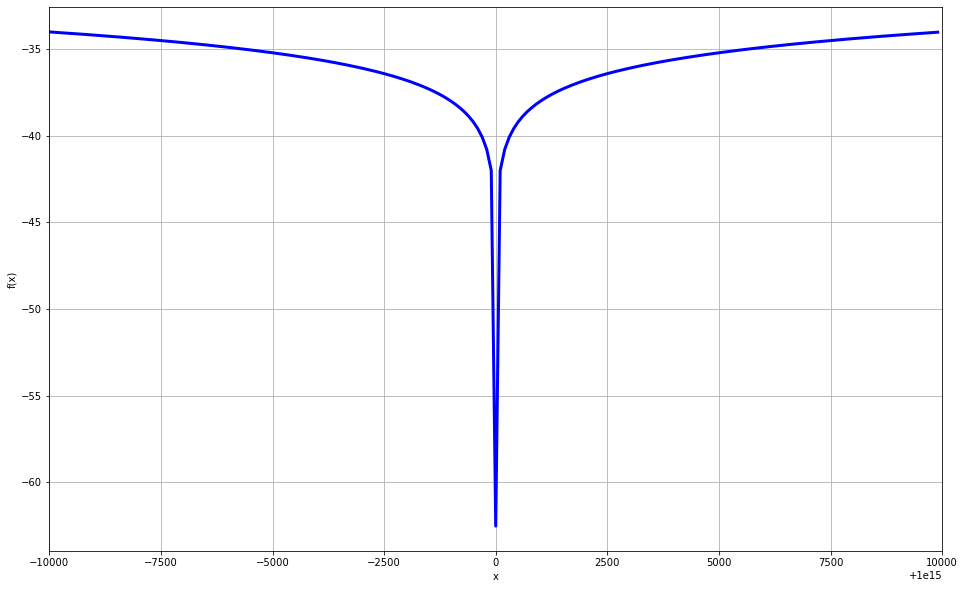

V0_out = 39476799777152668709647832.81783539093814628063401
phi0, mphi, A6 out =
 999999999999999.9999999999999999998900423191842168 0.0113294231892117892296889987666361137678644438219 0.08065781728055596099047882198870780708811028602107 0.00000004505394574884166694453001912420724955173444441088

------------------------------------------------------------------------



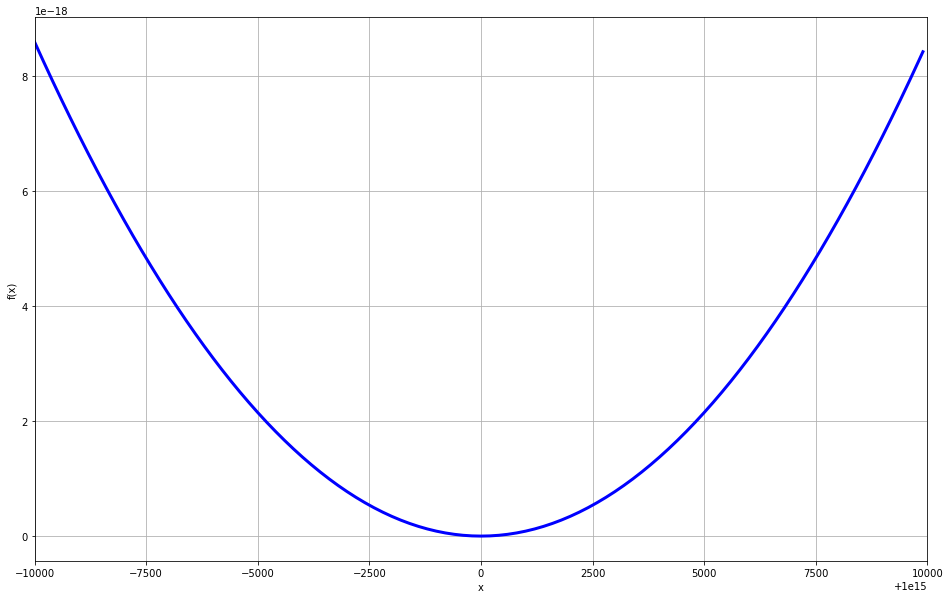

V0_out = 39476799777152668709647832.81783539093814628063401
phi0, mphi, A6 out =
 999999999999999.9999999999744999155896290582908896 0.0113285910136570830285899034565645263809322080344 0.08064579194596645879553688162106299078455007382221 0.0000000450461893361600490056177933409841275652525572813

------------------------------------------------------------------------

delta mphi = -7.345259691e-5 %
delta A6 = -0.0001490907515 %
delta lambda6 = -0.0001721583438 %
delta phi0 = -2.55000843e-26 %
delta V0 = 2.095358837e-50 %


In [10]:
#   lambda6_tree_ = mp.mpf('1')
#     mphi_tree_ = lambda6_tree_*mp.sqrt('10')*phi0_in**4/Mp**3
#     A6_tree_ = mphi_tree_*mp.sqrt('40')
#     normalization = V0/V_MSSM(phi0_in, infl_type, mphi_tree_, A6_tree_, lambda6_tree_, xi)
#     mphi_tree_, A6_tree_, lambda6_tree_ = mphi_tree_*mp.sqrt(normalization), A6_tree_*mp.sqrt(normalization), lambda6_tree_*mp.sqrt(normalization)
#     print(mphi_tree_)
#     # phi0B_list, phistar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list, alphas_list = aspic(0, 0.95, [phi0_in], 2e-9)
#     # A6_tree, lambda6_tree, mphi_tree, phi0_in = A6_list[0], lambda6_list[0], mphi_list[0], phi0B_list[0]
#     print(mphi_and_phi0_(A6_tree_, lambda6_tree_, mphi_tree_, phi0_in, infl_type, xi))

#     mp.plot(lambda i : mphi_and_phi0_(A6_tree, lambda6_tree*(1+i*0.1), mphi_tree, phi0_in, infl_type, xi)[1], xlim = (-10,10), points=10)
phi0 = mp.mpf('1000000000000000')
V0 = mp.mpf('39476799777152668709647832.81783539093814628063401')
xi = 1
infl_type = 'udd'
print('FI')
phi0, mphi, A6, lambda6 = final(phi0, V0, infl_type, xi)
VFI = lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6, xi)
mp.plot(lambda phi : mp.log10(eps1_(VFI, phi)), (phi0*0.99999999999, phi0*1.00000000001))
V0 = VFI(phi0)
print('V0_out =',V0)
print('phi0, mphi, A6 out =\n', phi0, mphi, A6, lambda6)


print('\n------------------------------------------------------------------------\n')

# phi0, mphi, A6, lambda6 = final(phi0, V0, infl_type, xi)
# print(mphi_and_phi0_(A6, lambda6, mphi, phi0, infl_type, xi))
# mp.plot(lambda i : mphi_and_phi0_(A6, lambda6*(1+i*0.00001), mphi, phi0, infl_type, xi)[1], xlim = (-10,10), points=10)

#     print('eps1 = 1')
phi0_, mphi_, A6_, lambda6_ = final_(phi0, V0, infl_type, xi)
VFI_ = lambda phi : V_MSSM(phi, infl_type, mphi_, A6_, lambda6_, xi)
mp.plot(lambda phi : mp.log10(eps1_(VFI_, phi)), (phi0_*0.99999999999, phi0_*1.00000000001))
V0_ = VFI_(phi0_)
print('V0_out =',V0_)
print('phi0, mphi, A6 out =\n', phi0_, mphi_, A6_, lambda6_)

print('\n------------------------------------------------------------------------\n')

ft_mphi_lle, ft_A6_lle, ft_lambda6_lle, ft_phi0_lle, ft_V0_lle = (mphi_-mphi)/mphi, (A6_-A6)/A6, (lambda6_-lambda6)/lambda6, (phi0_-phi0)/phi0, (V0_-V0)/V0
print('delta mphi =',nstr(ft_mphi_lle, 10), '%')
print('delta A6 =',nstr(ft_A6_lle, 10), '%')
print('delta lambda6 =',nstr(ft_lambda6_lle, 10), '%')
print('delta phi0 =',nstr(ft_phi0_lle, 10), '%')
print('delta V0 =',nstr(ft_V0_lle, 10), '%')

# Like above, but in a function

In [11]:

def plot_and_find_ft(V0, phi0_in):


    #####################
    infl_type = 'lle'   #
    xi = 1              #
    #####################
    phi0, mphi, A6, lambda6 = final(phi0_in, V0, infl_type, xi)
    phi0_, mphi_, A6_, lambda6_ = final_(phi0_in, V0, infl_type, xi)
    ft_mphi_lle, ft_A6_lle, ft_lambda6_lle, ft_alpha_lle = (mphi_-mphi)/mphi, (A6_-A6)/A6, (lambda6_-lambda6)/lambda6, (A6_**2/(40*mphi_**2)-A6**2/(40*mphi**2))/(A6**2/(40*mphi**2))
    print(end='.')

    #####################
    infl_type = 'udd'   #
    xi = 1              #
    #####################
    phi0, mphi, A6, lambda6 = final(phi0_in, V0, infl_type, xi)
    phi0_, mphi_, A6_, lambda6_ = final_(phi0_in, V0, infl_type, xi)
    ft_mphi_udd, ft_A6_udd, ft_lambda6_udd, ft_alpha_udd = (mphi_-mphi)/mphi, (A6_-A6)/A6, (lambda6_-lambda6)/lambda6, (A6_**2/(40*mphi_**2)-A6**2/(40*mphi**2))/(A6**2/(40*mphi**2))
    print(end='.')
    
    #####################
    infl_type = 'tree'  #
    xi = 'irrelevant'   #
    #####################
    phi0, mphi, A6, lambda6 = final(phi0_in, V0, infl_type, xi)
    phi0_, mphi_, A6_, lambda6_ = final_(phi0_in, V0, infl_type, xi)
    ft_mphi_tree, ft_A6_tree, ft_lambda6_tree, ft_alpha_tree = (mphi_-mphi)/mphi, (A6_-A6)/A6, (lambda6_-lambda6)/lambda6, (A6_**2/(40*mphi_**2)-A6**2/(40*mphi**2))/(A6**2/(40*mphi**2))
    print(end='.')
    
    return [[ft_mphi_tree, ft_mphi_lle, ft_mphi_udd], [ft_A6_tree, ft_A6_lle, ft_mphi_udd], [ft_A6_tree, ft_A6_lle, ft_A6_udd], [ft_alpha_tree, ft_alpha_lle, ft_alpha_udd]]


def plot_and_find_ft_detail(V0, phi0_in):

    ##############################################################################################
    print('\n##################################### LLe #######################################\n')#
    ##############################################################################################

    #####################
    infl_type = 'lle'   #
    xi = 1              #
    #####################

    # lambda6_tree_ = mp.mpf('1')
    # mphi_tree_ = lambda6_tree_*mp.sqrt('10')*phi0_in**4/Mp**3
    # A6_tree_ = mphi_tree_*mp.sqrt('40')
    # normalization = V0/V_MSSM(phi0_in, infl_type, mphi_tree_, A6_tree_, lambda6_tree_, xi)
    # mphi_tree_, A6_tree_, lambda6_tree_ = mphi_tree_*mp.sqrt(normalization), A6_tree_*mp.sqrt(normalization), lambda6_tree_*mp.sqrt(normalization)
    # print(mphi_tree_)
    # # phi0B_list, phistar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list, alphas_list = aspic(0, 0.95, [phi0_in], 2e-9)
    # # A6_tree, lambda6_tree, mphi_tree, phi0_in = A6_list[0], lambda6_list[0], mphi_list[0], phi0B_list[0]
    # print(mphi_and_phi0_(A6_tree_, lambda6_tree_, mphi_tree_, phi0_in, infl_type, xi))

    # mp.plot(lambda i : mphi_and_phi0_(A6_tree, lambda6_tree*(1+i*0.1), mphi_tree, phi0_in, infl_type, xi)[1], xlim = (-10,10), points=10)

    print('FI')
    phi0, mphi, A6, lambda6 = final(phi0_in, V0, infl_type, xi)
    VFI = lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6, xi)
    mp.plot(lambda phi : mp.log10(eps1_(VFI, phi)), (phi0*0.99999999999, phi0*1.00000000001))
    print('V0_out =',VFI(phi0))
    print('phi0, mphi, A6 out =\n', phi0, mphi, A6, lambda6)


    print('\n------------------------------------------------------------------------\n')

    # phi0, mphi, A6, lambda6 = final(phi0, V0, infl_type, xi)
    # print(mphi_and_phi0_(A6, lambda6, mphi, phi0, infl_type, xi))
    # mp.plot(lambda i : mphi_and_phi0_(A6, lambda6*(1+i*0.00001), mphi, phi0, infl_type, xi)[1], xlim = (-10,10), points=10)

    print('eps1 = 1')
    phi0_, mphi_, A6_, lambda6_ = final_(phi0_in, V0, infl_type, xi)
    VFI_ = lambda phi : V_MSSM(phi, infl_type, mphi_, A6_, lambda6_, xi)
    mp.plot(lambda phi : mp.log10(eps1_(VFI_, phi)), (phi0_*0.99999999999, phi0_*1.00000000001))
    print('V0_out =',VFI_(phi0_))
    print('phi0, mphi, A6 out =\n', phi0_, mphi_, A6_, lambda6_)

    print('\n------------------------------------------------------------------------\n')

    ft_mphi_lle, ft_A6_lle, ft_lambda6_lle, ft_alpha_lle = (mphi_-mphi)/mphi, (A6_-A6)/A6, (lambda6_-lambda6)/lambda6, (A6_**2/(40*mphi_**2)-A6**2/(40*mphi**2))/(A6**2/(40*mphi**2))
    print('delta mphi =',nstr(ft_mphi_lle, 10), '%')
    print('delta A6 =',nstr(ft_A6_lle, 10), '%')
    print('delta lambda6 =',nstr(ft_lambda6_lle, 10), '%')


    ##############################################################################################
    print('\n##################################### udd #######################################\n')#
    ##############################################################################################

    #####################
    infl_type = 'udd'   #
    xi = 1              #
    #####################

    print('FI')
    phi0, mphi, A6, lambda6 = final(phi0_in, V0, infl_type, xi)
    VFI = lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6, xi)
    mp.plot(lambda phi : mp.log10(eps1_(VFI, phi)), (phi0*0.99999999999, phi0*1.00000000001))
    print('V0_out =',VFI(phi0))
    print('phi0, mphi, A6 out =\n', phi0, mphi, A6, lambda6)


    print('\n------------------------------------------------------------------------\n')

    print('eps1 = 1')
    phi0_, mphi_, A6_, lambda6_ = final_(phi0_in, V0, infl_type, xi)
    VFI_ = lambda phi : V_MSSM(phi, infl_type, mphi_, A6_, lambda6_, xi)
    mp.plot(lambda phi : mp.log10(eps1_(VFI_, phi)), (phi0_*0.99999999999, phi0_*1.00000000001))
    print('V0_out =',VFI_(phi0_))
    print('phi0, mphi, A6 out =\n', phi0_, mphi_, A6_, lambda6_)

    print('\n------------------------------------------------------------------------\n')

    ft_mphi_udd, ft_A6_udd, ft_lambda6_udd, ft_alpha_udd = (mphi_-mphi)/mphi, (A6_-A6)/A6, (lambda6_-lambda6)/lambda6, (A6_**2/(40*mphi_**2)-A6**2/(40*mphi**2))/(A6**2/(40*mphi**2))
    print('delta mphi =',nstr(ft_mphi_udd, 10), '%')
    print('delta A6 =',nstr(ft_A6_udd, 10), '%')
    print('delta lambda6 =',nstr(ft_lambda6_udd, 10), '%')



    ###############################################################################################
#     print('\n##################################### tree #######################################\n')
    ###############################################################################################

    #####################
    infl_type = 'tree'  #
    xi = 'irrelevant'   #
    #####################

    print('FI')
    phi0, mphi, A6, lambda6 = final(phi0_in, V0, infl_type, xi)
    VFI = lambda phi : V_MSSM(phi, infl_type, mphi, A6, lambda6, xi)
    mp.plot(lambda phi : mp.log10(eps1_(VFI, phi)), (phi0*0.99999999999, phi0*1.00000000001))
    print('V0_out =',VFI(phi0))
    print('phi0, mphi, A6 out =\n', phi0, mphi, A6, lambda6)


    print('\n------------------------------------------------------------------------\n')

    print('eps1 = 1')
    phi0_, mphi_, A6_, lambda6_ = final_(phi0_in, V0, infl_type, xi)
    VFI_ = lambda phi : V_MSSM(phi, infl_type, mphi_, A6_, lambda6_, xi)
    mp.plot(lambda phi : mp.log10(eps1_(VFI_, phi)), (phi0_*0.99999999999, phi0_*1.00000000001))
    print('V0_out =',VFI_(phi0_))
    print('phi0, mphi, A6 out =\n', phi0_, mphi_, A6_, lambda6_)

    print('\n------------------------------------------------------------------------\n')
    
    ft_mphi_tree, ft_A6_tree, ft_lambda6_tree, ft_alpha_tree = (mphi_-mphi)/mphi, (A6_-A6)/A6, (lambda6_-lambda6)/lambda6, (A6_**2/(40*mphi_**2)-A6**2/(40*mphi**2))/(A6**2/(40*mphi**2))
    print('delta mphi =',nstr(ft_mphi_tree, 10), '%')
    print('delta A6 =',nstr(ft_A6_tree, 10), '%')
    print('delta lambda6 =',nstr(ft_lambda6_tree, 10), '%')
    
    return [[ft_mphi_tree, ft_mphi_lle, ft_mphi_udd], [ft_A6_tree, ft_A6_lle, ft_mphi_udd], [ft_A6_tree, ft_A6_lle, ft_A6_udd], [ft_alpha_tree, ft_alpha_lle, ft_alpha_udd]]

# Application of the function above for one phi0 and then for different phi0


##################################### LLe #######################################

FI


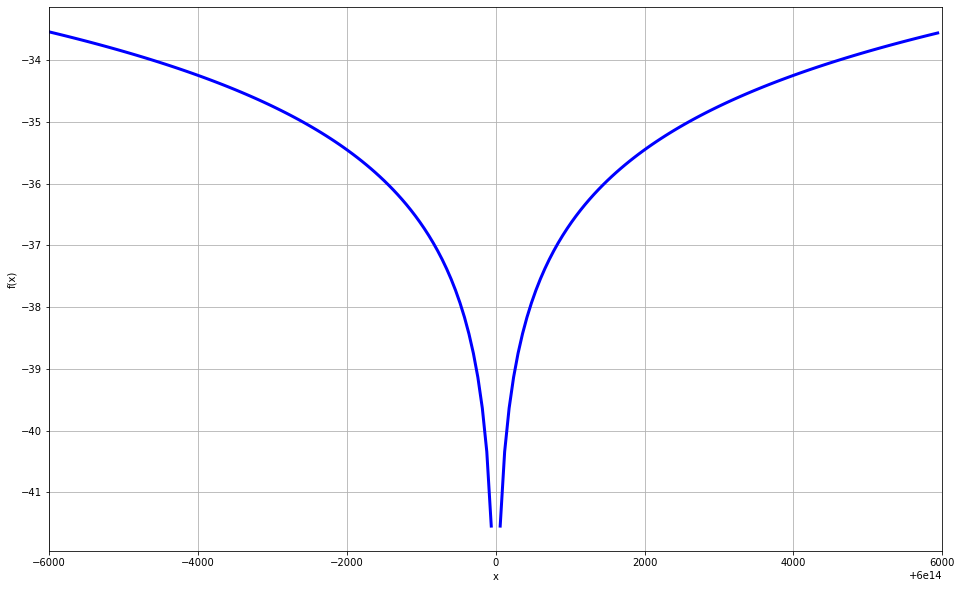

V0_out = 10000000000000000000000000000000000000000.0
phi0, mphi, A6 out =
 600000000000000.0000000000000000000397332170056869 310920.5805826005898329714648184229337045848120931 2103368.202176946450043812434706101837490363307123 10.02781840094493281306241766745048222222754860166

------------------------------------------------------------------------

eps1 = 1


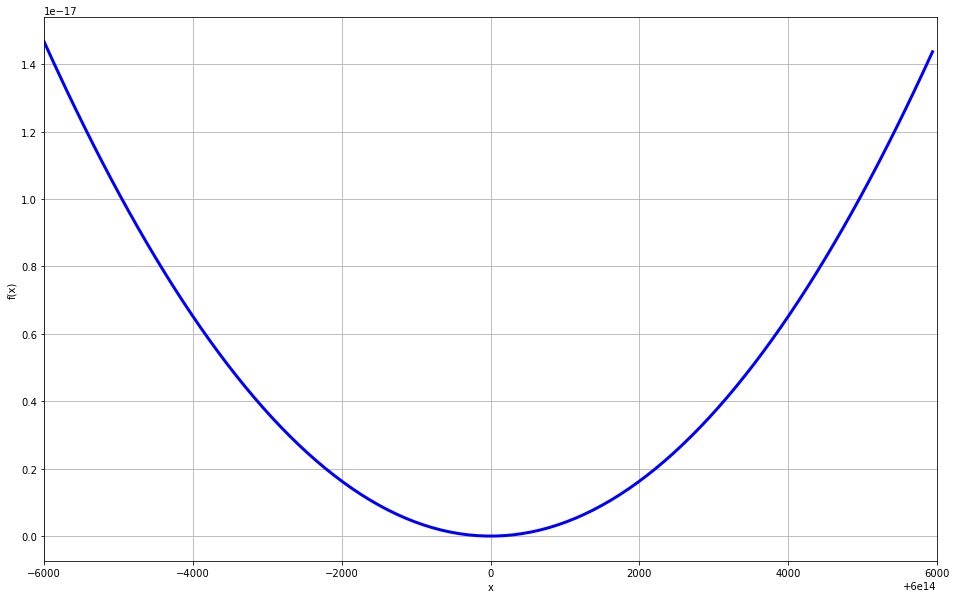

V0_out = 10000000000000000000000000000000000000000.0
phi0, mphi, A6 out =
 599999999999999.9999999999999656532681403177635647 310906.9427711606203104002277162074093149771814593 2103180.056149450440080133195237146889047844859997 10.02679118913908280387145350615740810723360300755

------------------------------------------------------------------------

delta mphi = -4.386268485e-5 %
delta A6 = -8.944987725e-5 %
delta lambda6 = -0.0001024362194 %

##################################### udd #######################################

FI


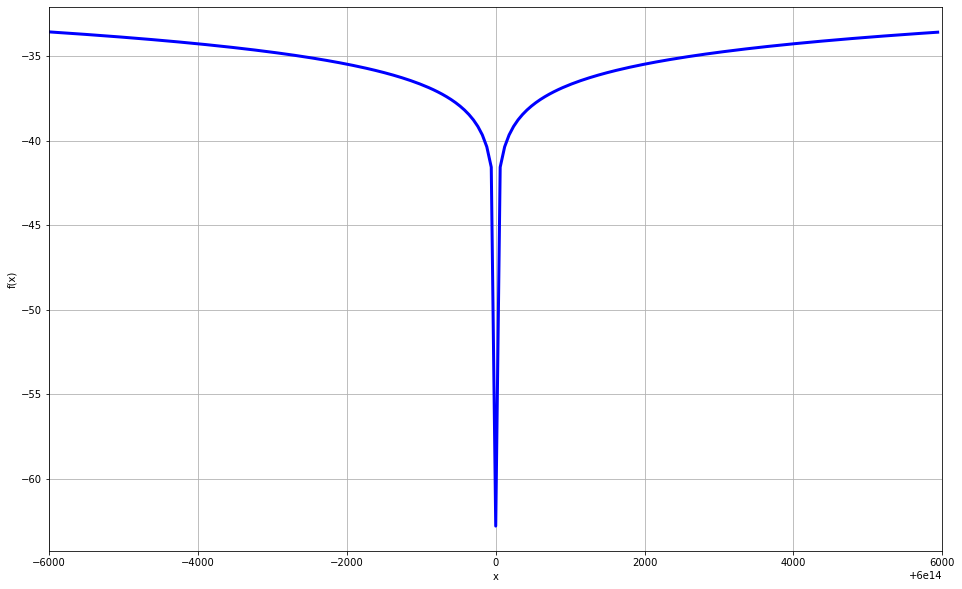

V0_out = 10000000000000000000000000000000000000000.0
phi0, mphi, A6 out =
 599999999999999.9999999999999999999035340061146343 297436.9987943344452456838596238704588304173878089 2158008.264814777670210934486829755797211008564277 8.935240017356367739331807260243415788970368832314

------------------------------------------------------------------------

eps1 = 1


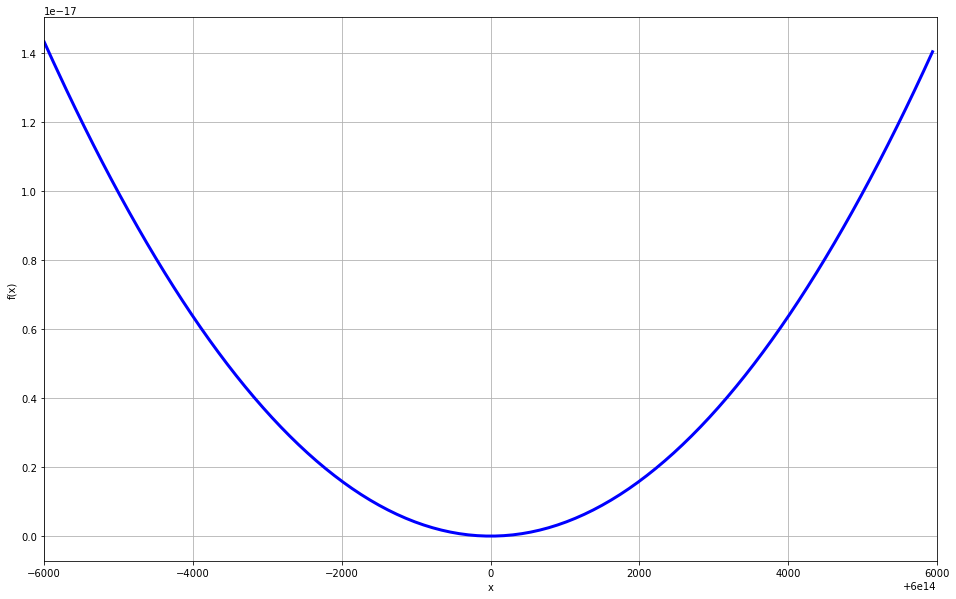

V0_out = 9999999999999999999999999999999999999999.999999999
phi0, mphi, A6 out =
 599999999999999.9999999999998703236681053509307785 297423.8891950863304221832952679043188184230899239 2157816.038897419617630512273284699052045007125076 8.934316946596285284430704518685196571149859739168

------------------------------------------------------------------------

delta mphi = -4.407521358e-5 %
delta A6 = -8.907561685e-5 %
delta lambda6 = -0.0001033067672 %
FI


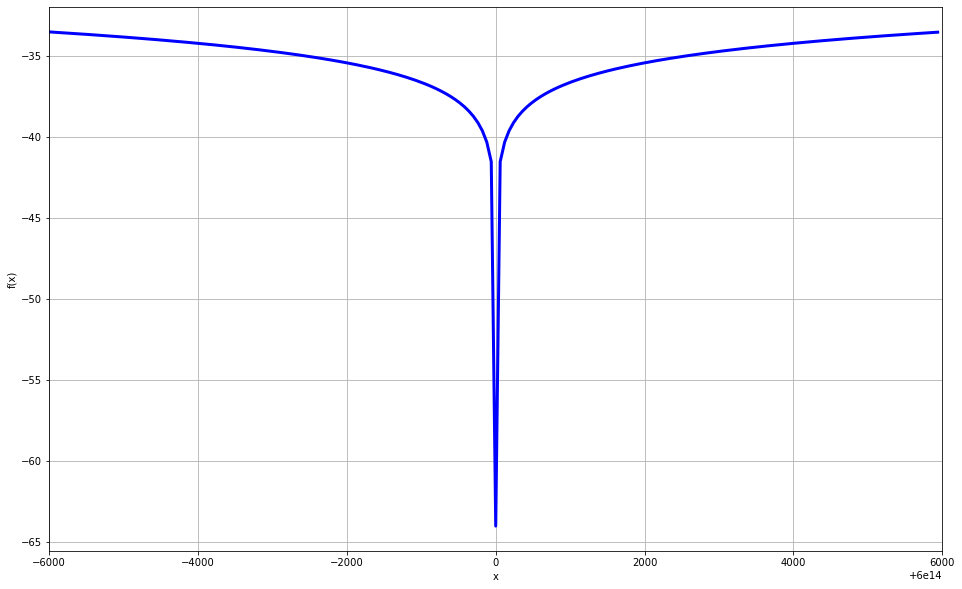

V0_out = 10000000000000000000000000000000000000000.0
phi0, mphi, A6 out =
 600000000000000.0000000000000000000057263282922951 322748.6121839514070982721166476367769800123351673 2041241.452319315081831070062264359685213854347089 11.2856654665269743397119197735915575849731443792

------------------------------------------------------------------------

eps1 = 1


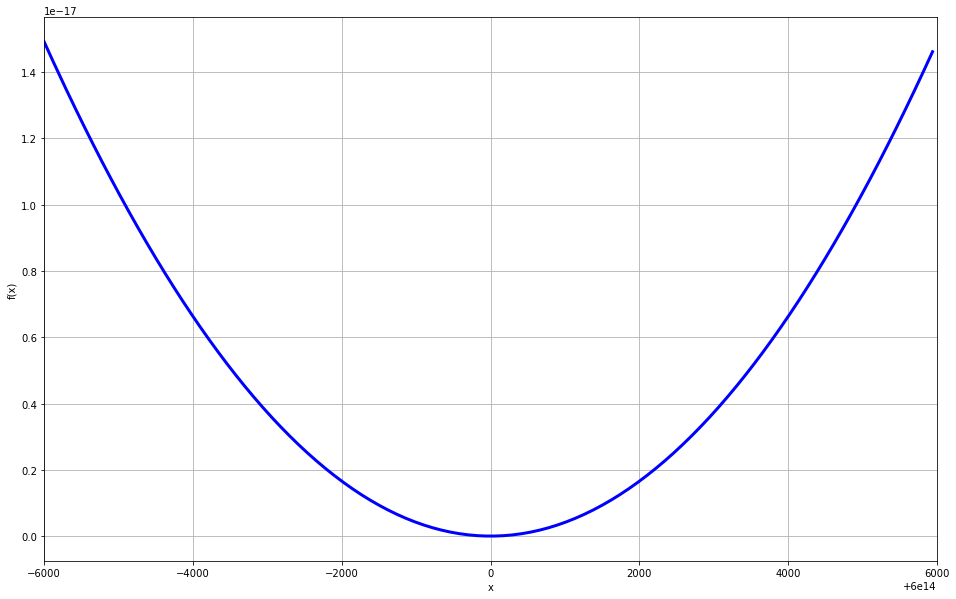

V0_out = 10000000000000000000000000000000000000000.0
phi0, mphi, A6 out =
 599999999999999.9999999999999956085656941733878771 322734.518730817100572361896614785738110878803143 2041057.233983073876709795982660694933900379741878 11.28451557182283822505592388943100248043938161869

------------------------------------------------------------------------

delta mphi = -4.366696742e-5 %
delta A6 = -9.024818501e-5 %
delta lambda6 = -0.0001018898449 %


[[mpf('-0.00004366696742377911700794999454216292915939324984141184'),
  mpf('-0.00004386268485159488800979394165522127101985671364675185'),
  mpf('-0.00004407521357885801138067277419357681726962671170338')],
 [mpf('-0.00009024818501108290970183575995652856049373091241350647'),
  mpf('-0.00008944987724987112144382412516449465961834919656263609'),
  mpf('-0.00004407521357885801138067277419357681726962671170338')],
 [mpf('-0.00009024818501108290970183575995652856049373091241350647'),
  mpf('-0.00008944987724987112144382412516449465961834919656263609'),
  mpf('-0.00008907561685105565325662189555288259712729643109631368')],
 [mpf('-0.00009316433347393738133667077819405256363771595075207972'),
  mpf('-0.00009117630575084770740786162516530499975374875273769007'),
  mpf('-0.00009000274830919719415324658529266426361826875800610482')]]

In [12]:
V0 = mp.mpf('1e40')
phi0 = mp.mpf('6e14')
plot_and_find_ft_detail(V0, phi0)

In [13]:
phi0_list = [mp.mpf(str(x)) for x in np.logspace(np.log10(6e14), np.log10(6e15), 10)[:6]]
V0 = mp.mpf('1e40')

mphi_ft_, A6_ft_, lambda6_ft_, alpha_ft_ = [], [], [], []
for phi0 in phi0_list:
    mphi_ft_phi0, A6_ft_phi0, lambda6_ft_phi0, alpha_ft_phi0 = plot_and_find_ft(V0, phi0)
    mphi_ft_.append(mphi_ft_phi0)
    A6_ft_.append(A6_ft_phi0)
    lambda6_ft_.append(lambda6_ft_phi0)
    alpha_ft_.append(alpha_ft_phi0)
    print('')



...
...
...
...
...
...


# Plot fine tuning for the different phi0

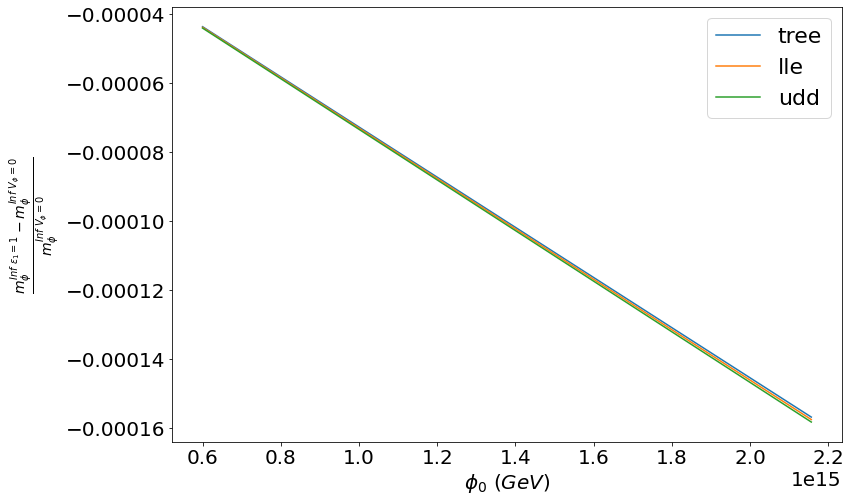

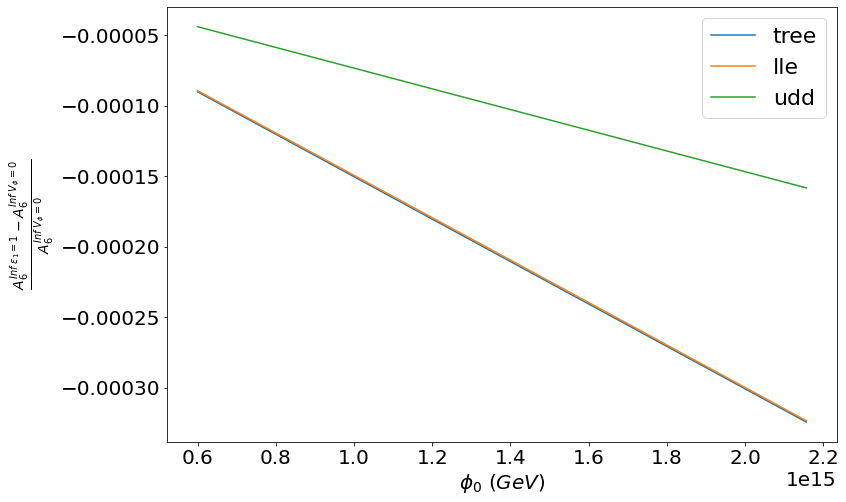

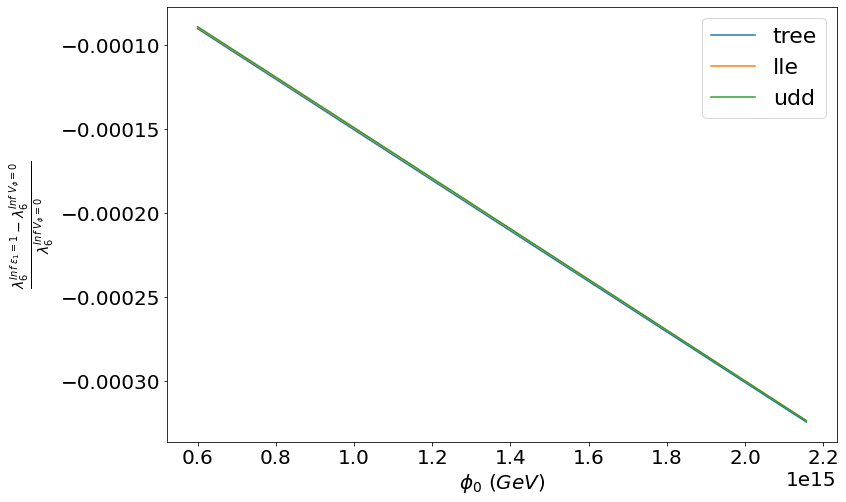

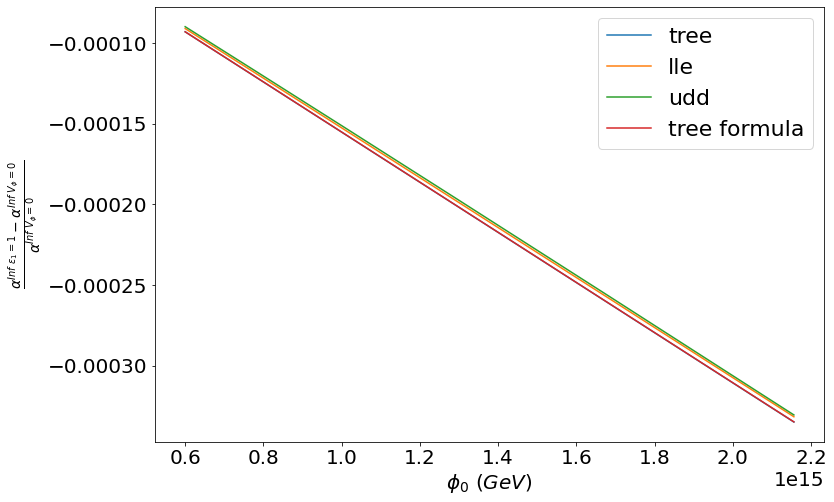

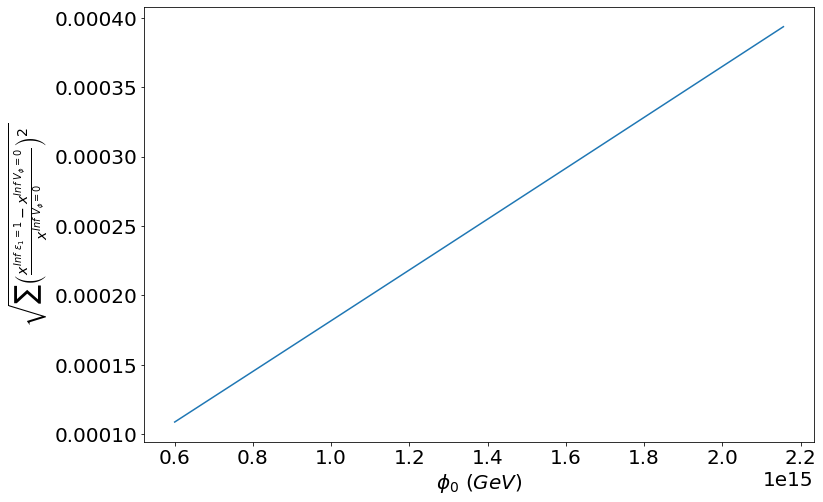

In [22]:
def define_plot_resolution():
    """
    This function allow to define the resolution of a matplotlib plot on a way
    wich is device independent. Put this before saving any of your plot to get
    homogeneous resolution.
    """

    fig = plt.gcf()  # get current figure

    DPI = fig.get_dpi()
#     fig.set_size_inches(1920.0 / float(DPI), 1080.0 / float(DPI))
    fig.set_size_inches(12, 8)
    ax = plt.gca()
    for tickLabel in ax.get_xticklabels()+ax.get_yticklabels():
        tickLabel.set_fontsize(20)
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.offsetText.set_fontsize(20)
    ax.xaxis.offsetText.set_fontsize(20)
    return
mphi_ft, A6_ft, lambda6_ft, alpha_ft = np.transpose(mphi_ft_), np.transpose(A6_ft_), np.transpose(lambda6_ft_), np.transpose(alpha_ft_)

label_list = ['tree', 'lle', 'udd']
plt.figure()
for i, mphi_ft_infl_type_ in enumerate(mphi_ft):
    plt.plot(phi0_list, mphi_ft_infl_type_, label=label_list[i])
plt.legend(fontsize = 22)
plt.ylabel(r'$\frac{m_\phi^{Inf\ \epsilon_1=1}-m_\phi^{Inf\ V_\phi=0}}{m_\phi^{Inf\ V_\phi=0}}$')
plt.xlabel(r'$\phi_0$ ($GeV$)')
define_plot_resolution()

plt.figure()
for i, A6_ft_infl_type_ in enumerate(A6_ft):
    plt.plot(phi0_list, A6_ft_infl_type_, label=label_list[i])
plt.legend(fontsize = 22)
plt.xlabel(r'$\phi_0$ ($GeV$)')
plt.ylabel(r'$\frac{A_6^{Inf\ \epsilon_1=1}-A_6^{Inf\ V_\phi=0}}{A_6^{Inf\ V_\phi=0}}$')
define_plot_resolution()


plt.figure()
for i, lambda6_ft_infl_type_ in enumerate(lambda6_ft):
    plt.plot(phi0_list, lambda6_ft_infl_type_, label=label_list[i])
plt.legend(fontsize = 22)
plt.xlabel(r'$\phi_0$ ($GeV$)')
plt.ylabel(r'$\frac{\lambda_6^{Inf\ \epsilon_1=1}-\lambda_6^{Inf\ V_\phi=0}}{\lambda_6^{Inf\ V_\phi=0}}$')
define_plot_resolution()

plt.figure()
for i, alpha_ft_infl_type_ in enumerate(alpha_ft):
    plt.plot(phi0_list, alpha_ft_infl_type_, label=label_list[i])
plt.plot(phi0_list, -4*np.sqrt(2)/15*np.array(phi0_list)/Mp, label = 'tree formula')
plt.legend(fontsize = 22)
plt.xlabel(r'$\phi_0$ ($GeV$)')
plt.ylabel(r'$\frac{\alpha^{Inf\ \epsilon_1=1}-\alpha^{Inf\ V_\phi=0}}{\alpha^{Inf\ V_\phi=0}}$')
define_plot_resolution()

plt.figure()
plt.plot(phi0_list, np.sqrt(lambda6_ft_infl_type_**2+A6_ft_infl_type_**2+mphi_ft_infl_type_**2))
plt.xlabel(r'$\phi_0$ ($GeV$)')
plt.ylabel(r'$\sqrt{\sum\left(\frac{x^{Inf\ \epsilon_1=1}-x^{Inf\ V_\phi=0}}{x^{Inf\ V_\phi=0}}\right)^2}$')
define_plot_resolution()
